*   AI Hub의 과적차량 도로 위험 데이터의 샘플 데이터를 다운로드, 과적 차량과 정상 차량의 데이터 각 170개를 140, 30개씩 나누어 학습과 검증에 사용하였습니다.

*   다운로드한 데이터는 다음 이미지와 같은 경로로 구글 드라이브에 저장 후 사용하였습니다.

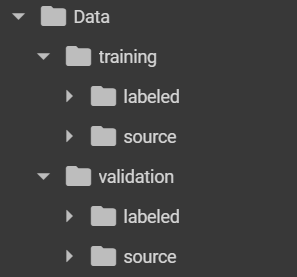



# **Detectron2 설치**

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15725, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 15725 (delta 201), reused 296 (delta 103), pack-reused 15277
Receiving objects: 100% (15725/15725), 6.51 MiB | 15.23 MiB/s, done.
Resolving deltas: 100% (11316/11316), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 985.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=5c8f2285bcea79f502d6d1d2bd529279fc64d2771f000af9a8ba7b4129a711e2
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=ad5df7cc28b9fb7399d23c18d33eac7935f613731704207c4a0e297fd6437dde
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# **데이터 변환**

In [5]:
from detectron2.structures import BoxMode

def convert_json_files(json_dir, image_dir, images, annotations, start_image_id, start_annotation_id):
    current_image_id = start_image_id
    current_annotation_id = start_annotation_id

    for json_file in os.listdir(json_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_dir, json_file)
            with open(json_path) as f:
                data = json.load(f)

            for entry in data["FILE"]:
                file_name = entry["FILE_NAME"]
                file_path = os.path.join(image_dir, file_name)
                if not os.path.exists(file_path):
                    continue

                # Read image size
                height, width = cv2.imread(file_path).shape[:2]

                # Append image info
                images.append({
                    "file_name": file_path,
                    "height": height,
                    "width": width,
                    "id": current_image_id
                })

                for item in entry["ITEMS"]:
                    if item["DRAWING"] == "Box":
                        bbox = list(map(float, item["BOX"].split(',')))
                        xmin, ymin, width, height = bbox[0], bbox[1], bbox[2], bbox[3]

                        # Determine class based on "CLASS" field
                        class_name = item["CLASS"]
                        if class_name == "적재불량":
                            category_id = 1
                        elif class_name == "정상차량":
                            category_id = 0
                        else:
                            continue  # Ignore entries that are not classified as "적재불량" or "정상차량"

                        # Append annotation info
                        annotations.append({
                            "bbox": [xmin, ymin, width, height],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "category_id": category_id,
                            "image_id": current_image_id,
                            "id": current_annotation_id,
                            "segmentation": [],
                            "area": width * height,
                            "iscrowd": 0
                        })
                        current_annotation_id += 1

                current_image_id += 1

    return current_image_id, current_annotation_id

def merge_json_files(training=True):
    base_dir = "/content/drive/MyDrive/Data/training" if training else "/content/drive/MyDrive/Data/validation" # 데이터 경로 지정 필요

    merged_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 0, "name": "normal_vehicle"},  # 정상 차량
            {"id": 1, "name": "overloaded_vehicle"}  # 적재불량 차량
        ]
    }

    current_image_id = 0
    current_annotation_id = 0

    json_dir = os.path.join(base_dir, "labeled")
    image_dir = os.path.join(base_dir, "source")

    current_image_id, current_annotation_id = convert_json_files(
        json_dir, image_dir,
        merged_data["images"], merged_data["annotations"],
        current_image_id, current_annotation_id
    )

    output_file = "merged_training_annotations.json" if training else "merged_validation_annotations.json"
    with open(output_file, 'w') as f:
        json.dump(merged_data, f, indent=4)

# Training 데이터셋 병합 및 변환
merge_json_files(training=True)

# Validation 데이터셋 병합 및 변환
merge_json_files(training=False)

In [6]:
from detectron2.data.datasets import register_coco_instances

# 파일 경로 설정
training_json = "merged_training_annotations.json"
validation_json = "merged_validation_annotations.json"
image_dir = "/content/drive/MyDrive/Data"  # 경로 지정 필요

# 데이터셋 등록
register_coco_instances("vehicle_train", {}, training_json, image_dir)
register_coco_instances("vehicle_val", {}, validation_json, image_dir)

# 메타데이터 가져오기
train_metadata = MetadataCatalog.get("vehicle_train")
val_metadata = MetadataCatalog.get("vehicle_val")

print("Train Dataset Metadata:", train_metadata)
print("Validation Dataset Metadata:", val_metadata)

Train Dataset Metadata: Metadata(name='vehicle_train', json_file='merged_training_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')
Validation Dataset Metadata: Metadata(name='vehicle_val', json_file='merged_validation_annotations.json', image_root='/content/drive/MyDrive/Data', evaluator_type='coco')


WARNING [06/09 06:08:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/09 06:08:32 d2.data.datasets.coco]: Loaded 280 images in COCO format from merged_training_annotations.json


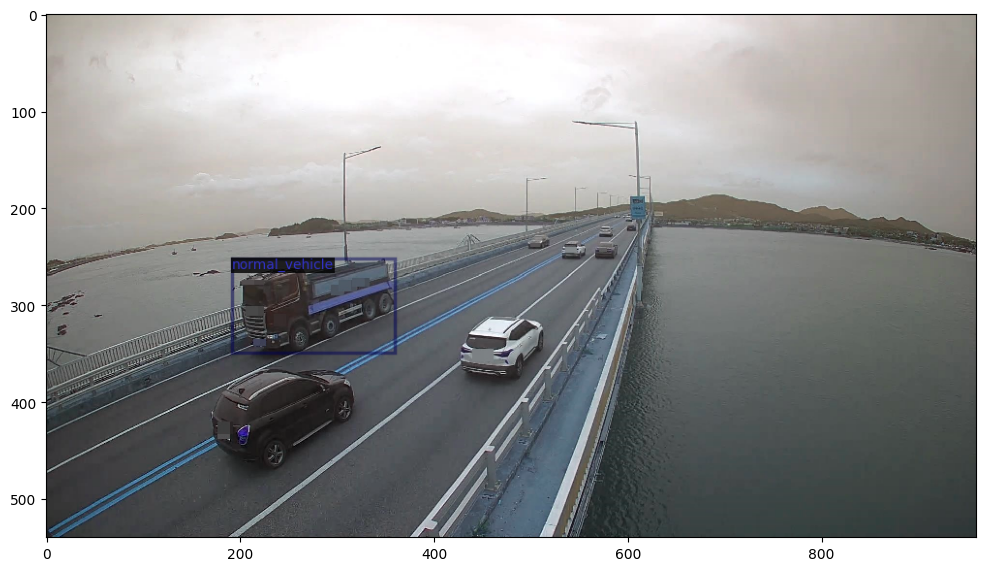

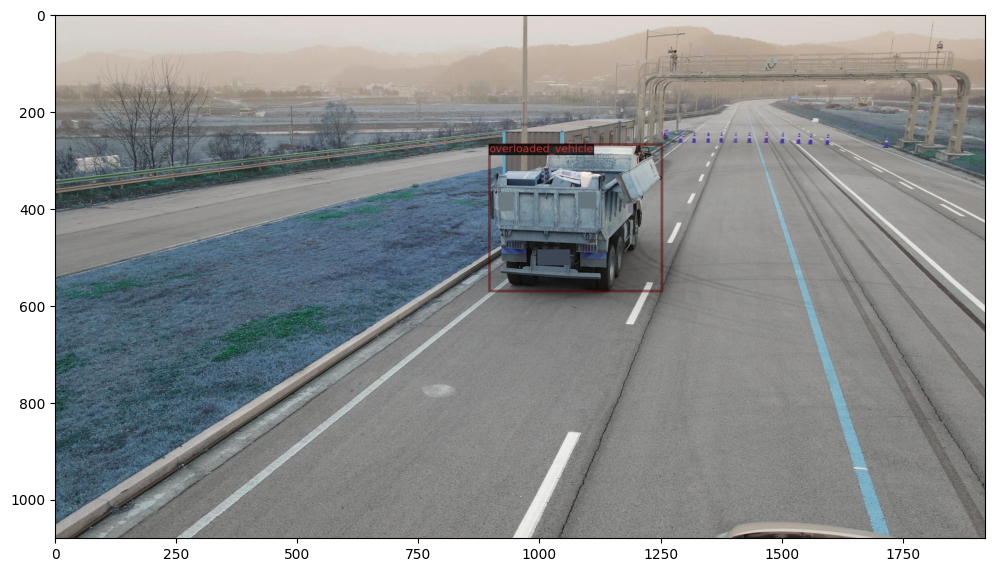

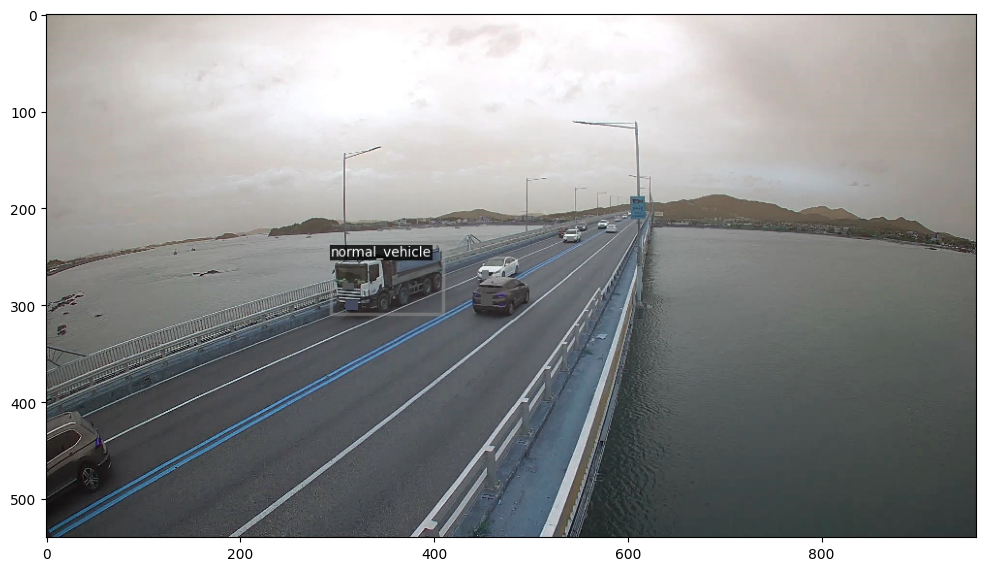

In [7]:
import matplotlib.pyplot as plt

# training 데이터셋 시각화
train_dataset_dicts = DatasetCatalog.get("vehicle_train")
for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

AI Hub에서 다운로드한 데이터를 detectron2에서 요구하는 형식으로 전환, 등록 후 시각화

# **학습 수행**

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)
cfg.DATASETS.TEST = ("vehicle_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 모델 사용
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # 학습 반복 횟수 조정
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 두 가지 클래스: 정상차량과 적재불량 차량

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# **성능 평가**

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # "적재불량 차량"과 "정상 차량" 두 가지 클래스
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 학습된 모델 가중치
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 테스트 시 사용할 confidence threshold

predictor = DefaultPredictor(cfg)

# 이미지에 대해 추론 수행
def perform_inference(image_path, predictor, metadata):
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}.")
        return

    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# 테스트 이미지 경로 설정
test_image_path = "/content/drive/MyDrive/Data/validation/source"  # 경로 지정 필요
perform_inference(test_image_path, predictor, MetadataCatalog.get("vehicle_train"))

# 평가를 위한 데이터 로더 및 평가자 초기화
evaluator = COCOEvaluator("vehicle_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "vehicle_val")

# 모델 성능 평가.
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(evaluation_results)